In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
import joblib


c:\Users\vivek\anaconda3\envs\urban_flood\Lib\site-packages\mlflow\protos\service_pb2.py:11: UserWarning: google.protobuf.service module is deprecated. RPC implementations should provide code generator plugins which generate code specific to the RPC implementation. service.py will be removed in Jan 2025
  from google.protobuf import service as _service
c:\Users\vivek\anaconda3\envs\urban_flood\Lib\site-packages\mlflow\utils\requirements_utils.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources  # noqa: TID251


In [6]:
# Load the engineered dataset (from Day 4)
data = pd.read_csv("../data/final_flood_dataset.csv")

print("Dataset shape:", data.shape)
data.head()



Dataset shape: (2, 13)


,timestamp,temp,humidity,pressure,wind_speed,rain_1h,rain_3h,rain_6h,rain_24h,rain_intensity,temp_delta,humidity_delta,flood_risk
0,2025-10-07 23:43:45.656266,22.84,88,1013,1.87,0,0.0,0.0,0.0,0.0,0.00,0.0,0
1,2025-10-08 15:04:20.942533,28.51,62,1009,2.00,0,0.0,0.0,0.0,0.0,5.67,-26.0,0


In [7]:
# Separate features and target
X = data.drop(columns=['flood_risk'])
y = data['flood_risk']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train size:", X_train.shape, " Test size:", X_test.shape)


Train size: (1, 12)  Test size: (1, 12)


In [9]:
# Convert timestamp to numeric features
X_train['timestamp'] = pd.to_datetime(X_train['timestamp'])
X_train['year'] = X_train['timestamp'].dt.year
X_train['month'] = X_train['timestamp'].dt.month
X_train['day'] = X_train['timestamp'].dt.day
X_train['hour'] = X_train['timestamp'].dt.hour
X_train['minute'] = X_train['timestamp'].dt.minute
X_train['second'] = X_train['timestamp'].dt.second
X_train.drop(columns=['timestamp'], inplace=True)

X_test['timestamp'] = pd.to_datetime(X_test['timestamp'])
X_test['year'] = X_test['timestamp'].dt.year
X_test['month'] = X_test['timestamp'].dt.month
X_test['day'] = X_test['timestamp'].dt.day
X_test['hour'] = X_test['timestamp'].dt.hour
X_test['minute'] = X_test['timestamp'].dt.minute
X_test['second'] = X_test['timestamp'].dt.second
X_test.drop(columns=['timestamp'], inplace=True)


In [10]:
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [11]:
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("✅ Model Performance:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


✅ Model Performance:
Accuracy: 1.0000
F1 Score: 0.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



c:\Users\vivek\anaconda3\envs\urban_flood\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\vivek\anaconda3\envs\urban_flood\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


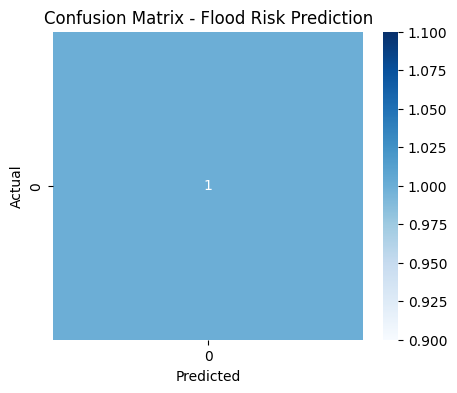

In [12]:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Flood Risk Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


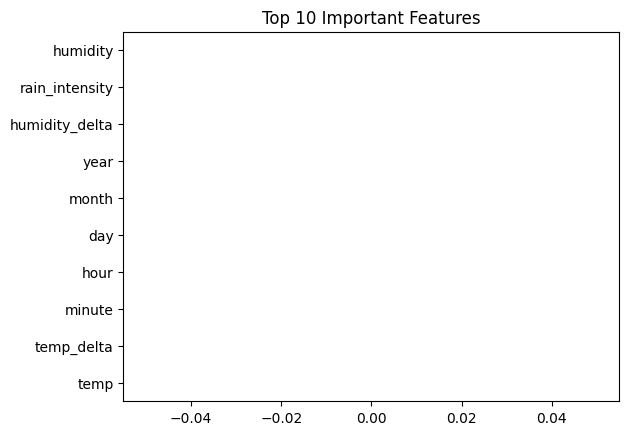

In [14]:
# Use the actual feature matrix used for training
importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).head(10).plot(kind='barh', color='teal')
plt.title("Top 10 Important Features")
plt.show()


In [15]:
mlflow.set_experiment("Flood Risk Prediction")

with mlflow.start_run(run_name="RandomForest_Baseline"):
    mlflow.log_param("n_estimators", 200)
    mlflow.log_param("max_depth", 12)
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("f1_score", f1)
    mlflow.sklearn.log_model(model, "model")

print("✅ MLflow run logged successfully!")


2025/10/11 23:33:51 INFO mlflow.tracking.fluent: Experiment with name 'Flood Risk Prediction' does not exist. Creating a new experiment.


✅ MLflow run logged successfully!


In [17]:
import os
import joblib

# Create folder if it doesn't exist
os.makedirs("models", exist_ok=True)

# Save the model
joblib.dump(model, "models/random_forest_baseline.pkl")
print("✅ Model saved as models/random_forest_baseline.pkl")


✅ Model saved as models/random_forest_baseline.pkl
